# Učitavanje biblioteka i podataka

In [468]:
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_predict
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [470]:
file_path = "heart.csv"
df = pd.read_csv(file_path)

[ https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction ]

# Osnovni pregled i struktura podataka

Pre detaljne analize, neophodno je steći osnovni uvid u strukturu skupa podataka.
U ovom koraku ispituju se dimenzije podataka, tipovi atributa i osnovni primeri zapisa.
Ova analiza omogućava identifikaciju potencijalnih problema kao što su neodgovarajući tipovi podataka,
nedostajuće vrednosti ili neočekivane kolone, koje mogu predstavljati izvor šuma.

In [474]:
display(df.head())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [476]:
df.shape

(918, 12)

In [478]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [480]:
df['HeartDisease'].unique() # target

array([0, 1], dtype=int64)

In [482]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [484]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

In [486]:
num_cols = numeric_df.columns

---

Ovi pokazatelji omogućavaju uočavanje raspona vrednosti, varijabilnosti podataka, kao i potencijalnih ekstremnih vrednosti koje mogu predstavljati šum u podacima.

In [489]:
numeric_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Nekoliko vrednosti ukazuju na potencijalni šum, odnosno na greške u podacima ili ekstremne autlajere koji nisu fiziološki mogući:

1. **RestingBP** (resting blood pressure [mm Hg])

* **Problem:** Minimalna vrednost (`min`) je **0.000000**.
* **Objašnjenje:** Živa osoba ne može imati krvni pritisak 0. Ovo je klasičan primer šuma ili nedostajuće vrednosti koja je greškom upisana kao nula.

2. **Cholesterol** (serum cholesterol [mm/dl])

* **Problem:** Minimalna vrednost (`min`) je **0.000000**.
* **Objašnjenje:** Biološki je nemoguće imati nivo holesterola 0 u krvi. Takođe, standardna devijacija (`std`) od **109.38**, što je veoma visoko u odnosu na prosek (`mean`) od **198**. To ukazuje na prisustvo nula koje vuku prosek nadole.

3. **Oldpeak** (oldpeak = ST [Numeric value measured in depression])

* **Problem:** Minimalna vrednost (`min`) je **-2.600000**.
* **Objašnjenje:** `Oldpeak` se u kardiološkim setovima podataka obično meri od nule nagore. Negativne vrednosti se često smatraju anomalijama ili greškama u unosu.

---

Histogrami pomažu u identifikaciji asimetričnih raspodela, prisustva outliera i koncentracije vrednosti,
što su česti izvori šuma u realnim skupovima podataka.

In [493]:
def plot_numeric_distributions(df, num_cols, cols_per_row=4, bins=20, figsize_per_col=4):
    
    num_plots = len(num_cols)
    rows = math.ceil(num_plots / cols_per_row)
    layout_tuple = (rows, cols_per_row)
    figsize = (cols_per_row * figsize_per_col, rows * figsize_per_col)
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    
    if rows * cols_per_row > 1:
        axes = axes.flatten()
    elif rows == 1 and cols_per_row == 1:
        axes = [axes]
    else:
        axes = axes.ravel()
    
    for i, col in enumerate(num_cols):
        sns.histplot(
            data=df,
            x=col,
            ax=axes[i],
            kde=True,
            bins=bins,
            color='skyblue',
            stat='count'
        )
        
        for line in axes[i].lines:
            if line.get_linestyle() == '-' and line.get_linewidth() > 1:
                line.set_color('red')
                break
        
        axes[i].set_title(f'Distribucija: {col}', fontsize=12)
        axes[i].set_xlabel('')
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Histogram distribucije (Seaborn + crvena KDE linija)', fontsize=18, y=0.98)
    plt.show()

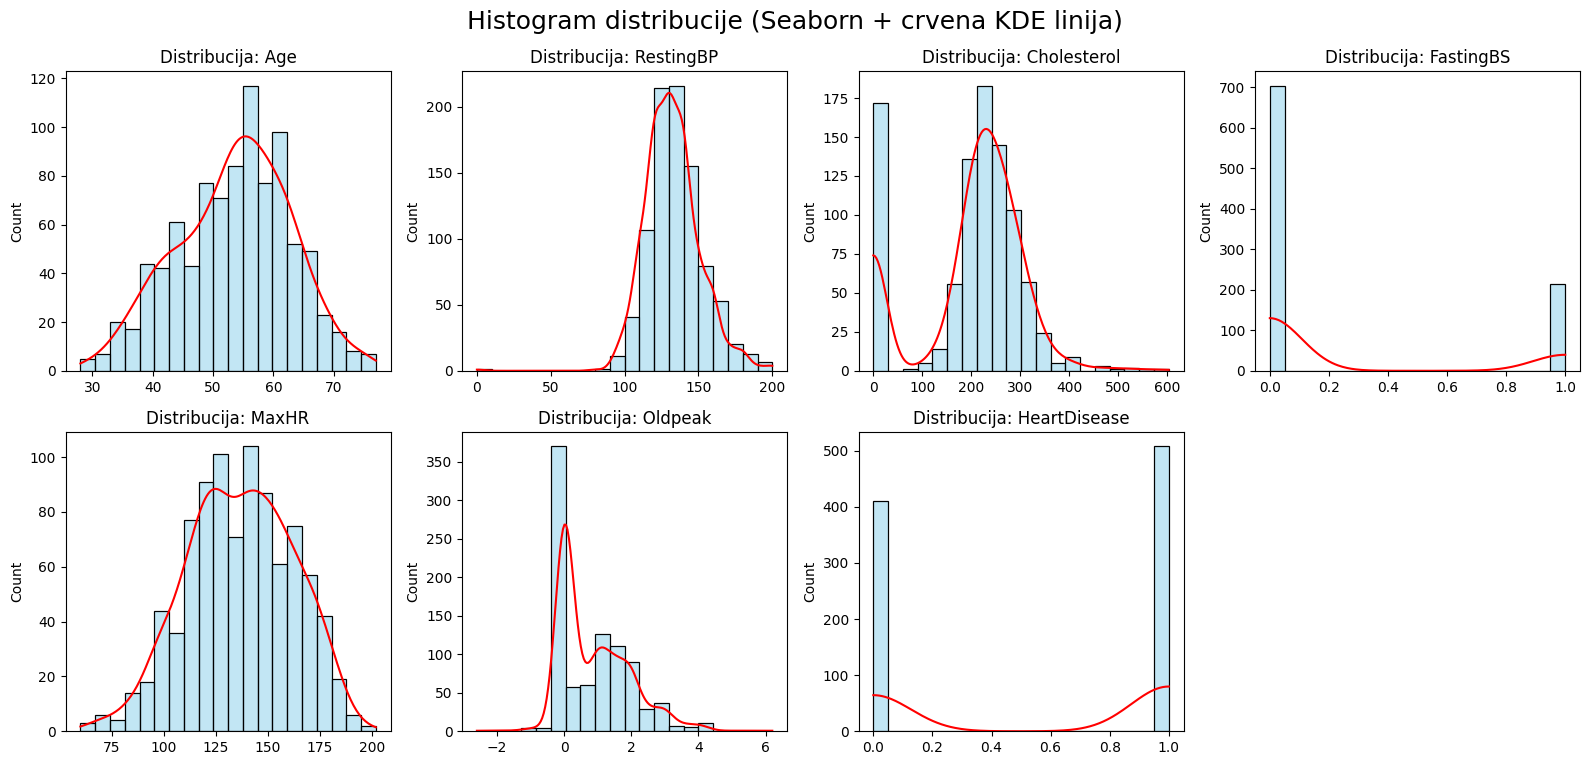

In [495]:
plot_numeric_distributions(numeric_df, numeric_df.columns)

1. Ogroman skok na nuli kod `Cholesterol`

2. Usamljena tačka na nuli kod `RestingBP`

Na grafikonu , skroz levo, vidi se jedan sićušan stubić na nuli.
To je onaj jedan podatak sa vrednošću 0 koji smo videli u tabeli. On je autlajer jer se nalazi daleko od glavne grupe podataka koja počinje tek od oko 80-90 mmHg.

3. Negativne vrednosti kod `Oldpeak`-a

Grafikon pokazuje da to nije samo jedan slučajan podatak, već postoji mali klaster vrednosti ispod nule.

---

U ovom delu analize ispituje se raspodela vrednosti kategorijalnih atributa.
Cilj je da se identifikuje eventualna neuravnoteženost klasa ili retke kategorije,
koje mogu negativno uticati na modele i povećati nivo šuma u podacima.

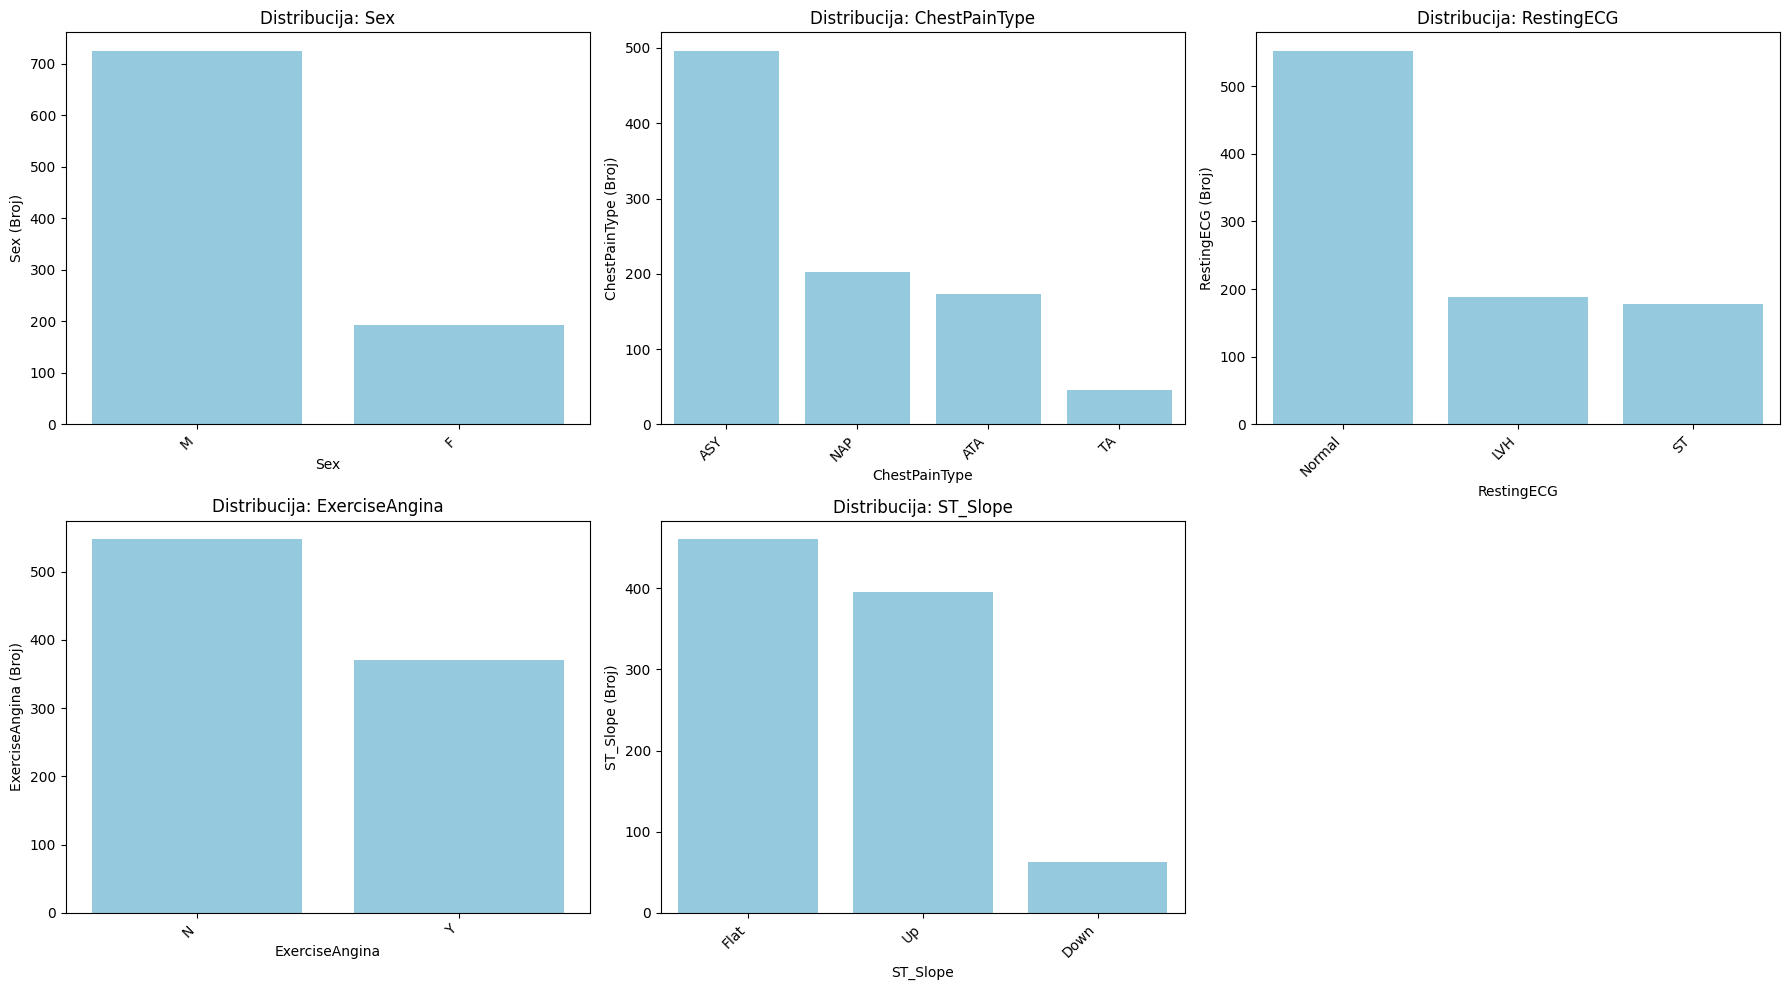

In [498]:
nonnumerical_df = df.select_dtypes(exclude="number")
cols = nonnumerical_df.columns
num_columns = len(cols)

cols_per_row = 3 
rows = (num_columns + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 5 * rows)) 

for i, col in enumerate(cols):
    plt.subplot(rows, cols_per_row, i + 1)
    
    sns.countplot(
            data=df,
            x=df[col].astype(str),
            color='skyblue',
            order=df[col].value_counts().index
        )
    
    plt.title(f'Distribucija: {col}')
    plt.xlabel(col)
    plt.ylabel(f'{df[col].name} (Broj)') 
    plt.xticks(rotation=45, ha='right') 

plt.tight_layout() 
plt.show()

Podaci koji mogu biti šumni:

1. Klasa **TA** u `ChestPainType`

2. Klasa **Down** u `ST_Slope`

3. Disproporcija u `Sex`

One-Hot enkodiranje će adekvatno adresirati ove kolone i omogućiti modelu da jasno uoči težinu svake kategorije nezavisno. Umesto balansiranja redova, ostavljam modelu da kroz enkodirane kolone sam nauči značaj manjinskih klasa.

---

Korelaciona analiza se koristi za ispitivanje međusobnih odnosa između numeričkih atributa.
Atributi sa visokom međusobnom korelacijom mogu biti redundantni, dok atributi sa veoma slabom korelacijom mogu doprineti šumu.
Vizuelizacija korelacione matrice olakšava interpretaciju ovih odnosa i predstavlja osnovu za dalju selekciju i transformaciju podataka.

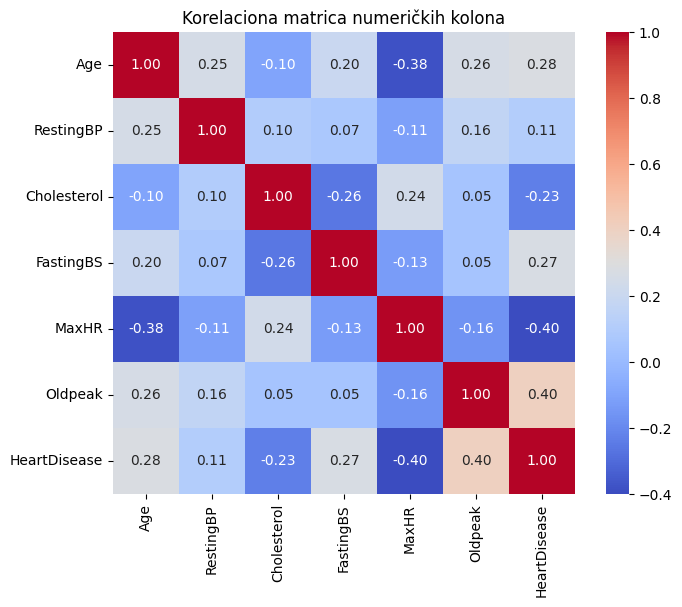

In [501]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Korelaciona matrica numeričkih kolona")
plt.show()

1. `Cholesterol` i `HeartDisease` (negativna korelacija: -0.23)

Matrica pokazuje da kako holesterol raste, verovatnoća srčanog oboljenja opada (negativna korelacija). Sa medicinske tačke gledišta, ovo je besmisleno.
Nule u holesterolu (šum) veštački stvaraju sliku da ljudi sa niskim holesterolom imaju srčane probleme, čime se kvari stvarna korelacija.

2. `RestingBP` i `HeartDisease` (slaba korelacija: 0.11)

Korelacija od samo 0.11 je veoma niska za krvni pritisak, koji je obično značajan faktor rizika.
Nula koju smo uočili smanjuje statističku značajnost ove kolone.

3. `Oldpeak` i `HeartDisease` (jaka korelacija: 0.40)

Smislena korelacija, ali negativne vrednosti u `Oldpeak` smanjuju korelaciju, pa i značaj kolone.

---

Box-plot analiza omogućava potvrdu prethodno uočenih obrazaca i potencijalnih izvora šuma.

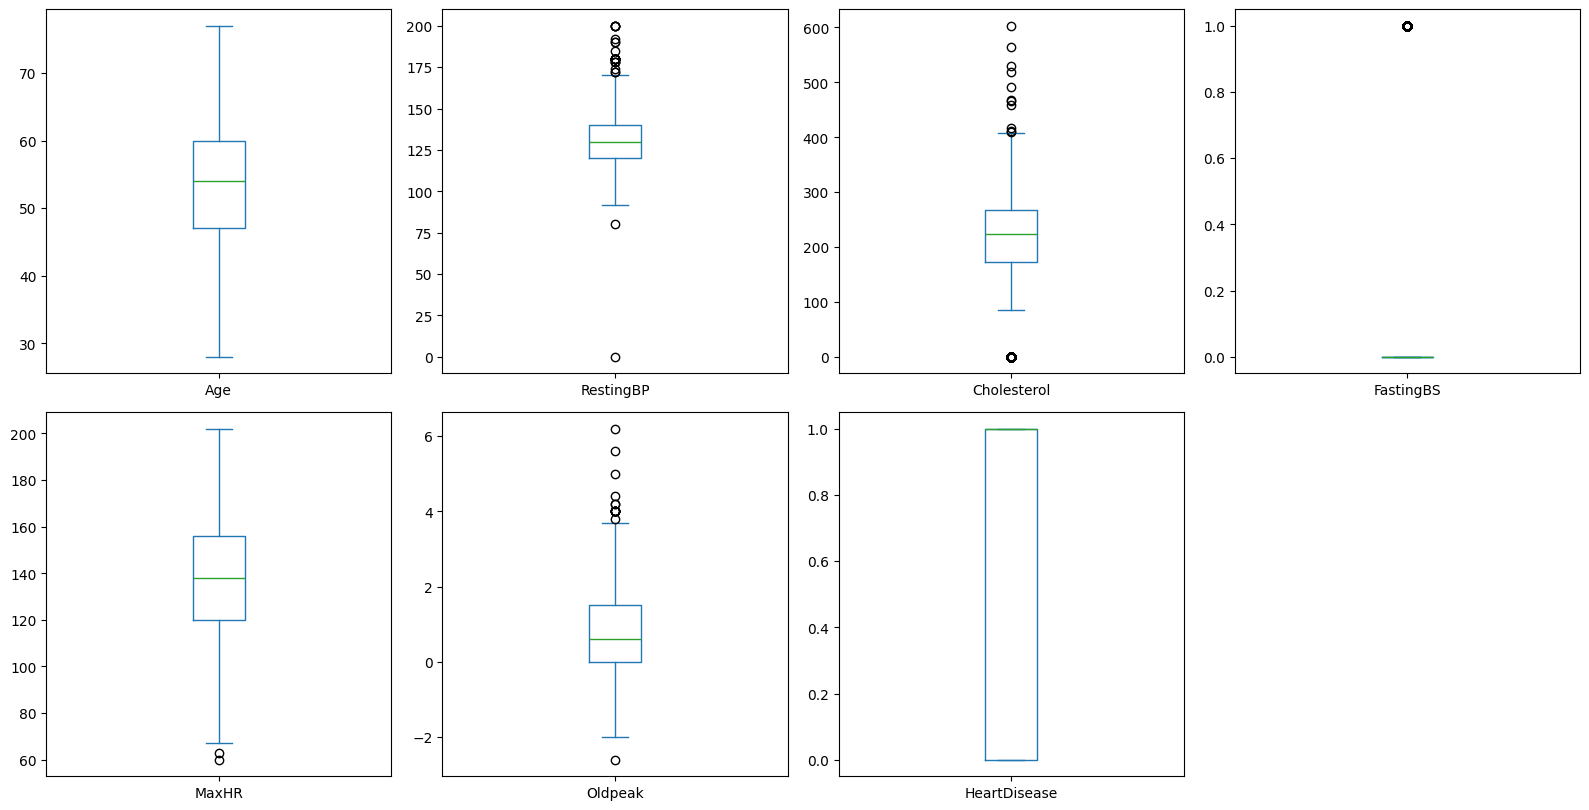

In [505]:
ncols = 4
nrows = int(np.ceil(df.shape[1] / ncols))

df.plot(kind='box', subplots=True, layout=(nrows, ncols), figsize=(16, 4*nrows), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Evo kako ovi grafikoni potvrđuju postojanje šuma:

1. Potvrda nemogućih nula (`RestingBP` i `Cholesterol`)

2. Potvrda negativnih vrednosti (`Oldpeak`)

Na grafikonu za **Oldpeak**, jasno se vidi kružić ispod nule (kod **-2.6**). To potvrđuje da to nije deo normalne distribucije, već statistički incident u ovom skupu podataka.

---

In [508]:
df_encoded = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

In [510]:
df_encoded.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

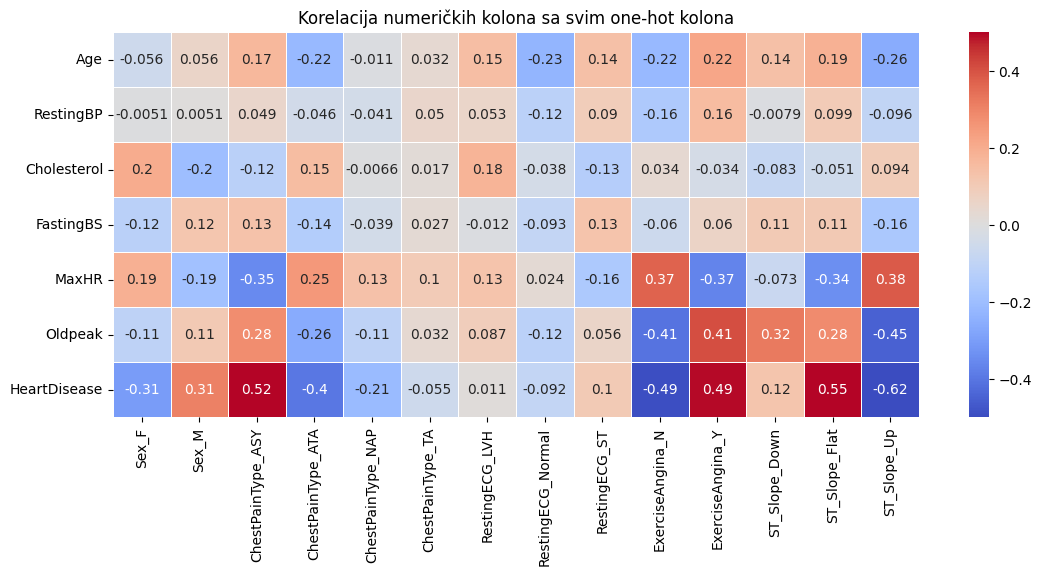

In [511]:
correlation_matrix = df_encoded.corr()

numerical_cols = df_encoded.select_dtypes(include=['number']).columns

one_hot_cols = [col for col in df_encoded.columns if '_' in col and col not in numerical_cols]

corr_subset = correlation_matrix.loc[numerical_cols, one_hot_cols]

plt.figure(figsize=(13, 5))
sns.heatmap(
    corr_subset,
    annot=True,
    cmap='coolwarm',
    center=0,
    vmin=-0.5,
    vmax=0.5,
    linewidths=0.5
)
plt.title('Korelacija numeričkih kolona sa svim one-hot kolona')
plt.show()

1. Čisti prediktori sa najjačim signalom

Ove kolone imaju veoma visoke korelacije sa `HeartDisease`, što znači da je šum u njima nizak ili zanemarljiv:

**`ST_Slope_Up` (-0.62) i `ST_Slope_Flat` (0.55)**
**`ExerciseAngina_Y` (0.49) i `ChestPainType_ASY` (0.52)**

2. Potvrda šuma u koloni `Cholesterol`

Korelacije sa svim ostalim faktorima su **izuzetno niske** (npr. sa `ChestPainType_ASY` je **-0.12**).
U medicini, visok holesterol je često povezan sa drugim faktorima rizika. Činjenica da on ovde ne reaguje skoro ni na šta statistički potvrđuje da su one **nule** koje smo videli na histogramu potpuno ubile informativnu vrednost ove kolone.

3. `Oldpeak` korelacije

Ima jaku negativnu korelaciju sa `ST_Slope_Up` (**-0.45**).
Ovo nam govori da je, uprkos onim negativnim vrednostima (poput **-2.6**), ova kolona i dalje veoma moćna. Ipak, čišćenjem tih par negativnih autlajera, ovi koeficijenti bi postali još stabilniji.

* Kategorija `ChestPainType_TA` ima korelaciju od samo **-0.055**. Te kategorije ima premalo da bi bila statistički značajna.

---

# Primena različitih tehnika za uklanjanje šuma 

Na nezavisnim kopijama originalnih podataka u nastavku se primenjuju različite tehnike uklanjanja šuma i rezultati se čuvaju u dictonary-ju `df_dict`.

In [518]:
df_dict=dict()
df_dict['Original'] = df_encoded

## Metode uklanjanja šuma

U nastavku rada biće primenjene sledeće metode uklanjanja šuma iz podataka:

- Binning
- Regresija
- IQR
- LocalOutlierFactor
- IsolationForest
- KMeans
- Ensemble Filter
- CrossValidatedCommittees Filter
- IterativePartitioning Filter

Svaka od navedenih metoda biće posebno analizirana, a njihov uticaj na performanse modela biće evaluiran primenom iste procedure treniranja i testiranja, kao i uklanjanje duplikata i redukcija dimenzionalnosti.

### Binning

#### Zašto `smooth_by_means_per_bin` za **`RestingBP`**?

Na osnovu histograma za **`RestingBP`**:

* Normalna distribucija
* Odsustvo ekstremnih autlajera (osim nule)
* Kada je raspodela simetrična i nema mnogo ekstremnih vrednosti koje vuku prosek, aritmetička sredina (`mean`) je najbolja jer uzima u obzir doprinos svake vrednosti.

#### Zašto `smooth_by_medians_per_bin` za **`Oldpeak`** i **`Cholesterol`**?

**Za `Cholesterol`:**

* Histogram pokazuje ogroman broj nula i veoma dugačak rep sa desne strane
* Srednja vrednost (`mean`) bi bila drastično povučena nadole zbog onih 170+ nula ili nagore zbog ekstremnih vrednosti od 600.
* Medijana (`median`) je imuna na ove ekstremne tačke; ona bira središnju vrednost i tako ignoriše šum, zadržavajući tipičnu vrednost za taj bin.

**Za `Oldpeak`:**

* Oldpeak ima specifičnu raspodelu gde je većina vrednosti 0, a zatim opada ka većim brojevima, uz prisustvo onih sumnjivih negativnih vrednosti
* Pošto Oldpeak meri nivo depresije, medijana bolje čuva stepenastu prirodu ovog merenja i sprečava da par ekstremno visokih ili negativnih vrednosti unutar jednog k-means bin-a veštački promene nivo te grupe.

#### Zašto ne `smooth by boundaries`?

Kao što smo videli na box-plotovima, dataset ima dosta autlajera (kružića van brkova).

* Ako koristimo *smooth by boundaries*, a bin sadrži autlajer, taj autlajer postaje jedna od granica.

Histogrami pokazuju da podaci imaju jasne centre (vrhove na KDE crvenoj liniji).

* **Smooth by boundaries* gura podatke ka ivicama bina, stvarajući veštačke "praznine" u sredini distribucije.

U kodu koristimo `strategy="kmeans"` u `KBinsDiscretizer`.

* K-means već grupiše podatke oko centroida (centra).

In [524]:
def smooth_by_means_per_bin(values, original_values):
    smoothed = np.zeros_like(values, dtype=float)
    for b in np.unique(values):
        mask = values == b
        smoothed[mask] = np.mean(original_values[mask])
    return smoothed

def smooth_by_medians_per_bin(values, original_values):
    smoothed = np.zeros_like(values, dtype=float)
    for b in np.unique(values):
        mask = values == b
        smoothed[mask] = np.median(original_values[mask])
    return smoothed


df_binning = df_encoded.copy()

eq = KBinsDiscretizer(n_bins=30, encode="ordinal", strategy="kmeans")
cols_to_bin = ['Oldpeak', 'Cholesterol', 'RestingBP'] 

eq.fit(df_binning[cols_to_bin])
binned_data = eq.transform(df_binning[cols_to_bin])
df_binned = pd.DataFrame(binned_data, columns=cols_to_bin, index=df_binning.index)
df_binning[cols_to_bin] = df_binned

df_binning['Oldpeak'] = smooth_by_medians_per_bin(df_binning['Oldpeak'].values, df_encoded['Oldpeak'].values)
df_binning['Cholesterol'] = smooth_by_medians_per_bin(df_binning['Cholesterol'].values, df_encoded['Cholesterol'].values)
df_binning['RestingBP'] = smooth_by_means_per_bin(df_binning['RestingBP'].values, df_encoded['RestingBP'].values)

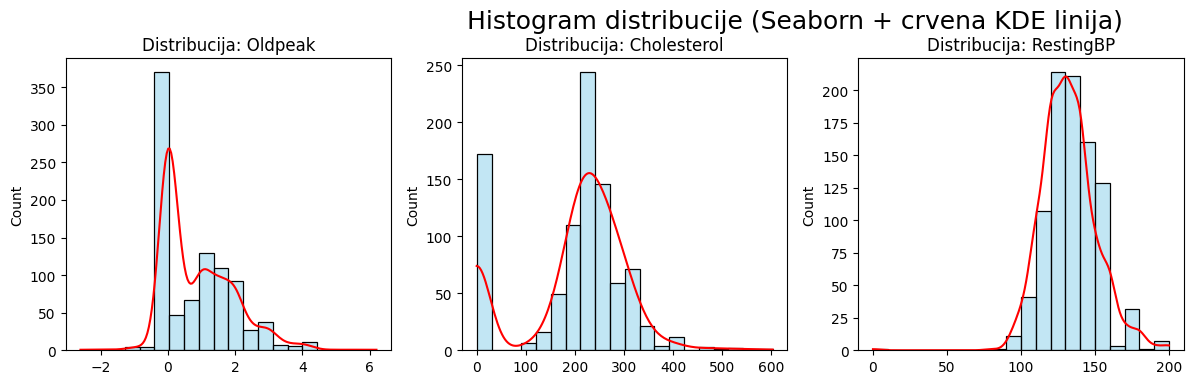

In [526]:
plot_numeric_distributions(df_binning, cols_to_bin)

In [527]:
df_dict['Binning'] = df_binning

### Regression


Koristimo linearnu regresiju da zamenimo originalne vrednosti u kolonama `Oldpeak`, `Cholesterol` i `RestingBP` predviđenim vrednostima na osnovu ostalih karakteristika. Cilj je smanjenje šuma.

In [532]:
df_reg = df_encoded.copy()

for col in cols_to_bin:
    X_features = df_reg.drop(columns=[col])
    y_target = df_reg[col]

    model = LinearRegression()
    model.fit(X_features, y_target)

    df_reg[col] = model.predict(X_features)

In [534]:
df_dict['Regression'] = df_reg

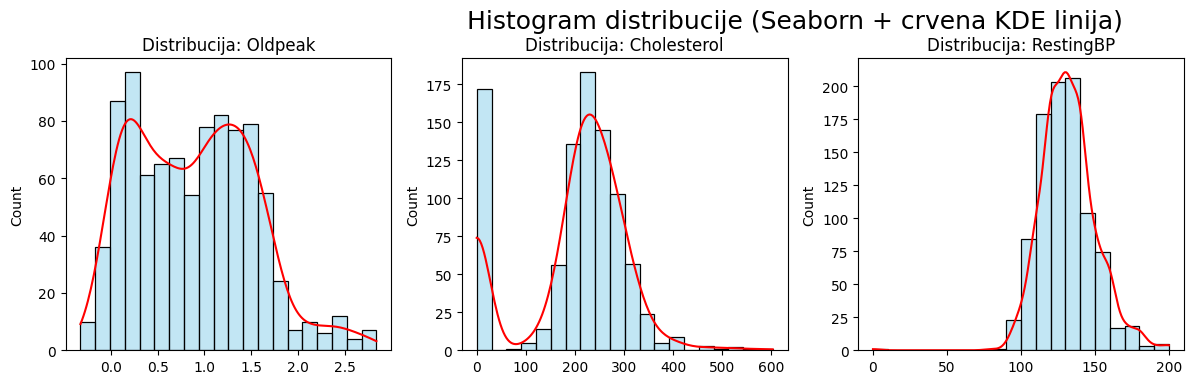

In [536]:
plot_numeric_distributions(df_reg, cols_to_bin)

### Outlier analysis

#### IQR

Ova ćelija identifikuje i uklanja ekstremne vrednosti iz kolona `Oldpeak`, `Cholesterol`, `RestingBP` i `MaxHR` (`MaxHR` je na boxplotu imao autlejere). Koristimo metodu IQR kako bismo zadržali samo podatke koji se nalaze unutar granica.

In [541]:
noisy_cols = cols_to_bin + ['MaxHR']
df_iqr = df_encoded.copy()

for col in noisy_cols:
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_iqr = df_iqr[(df_iqr[col] >= lower_bound) & (df_iqr[col] <= upper_bound)]

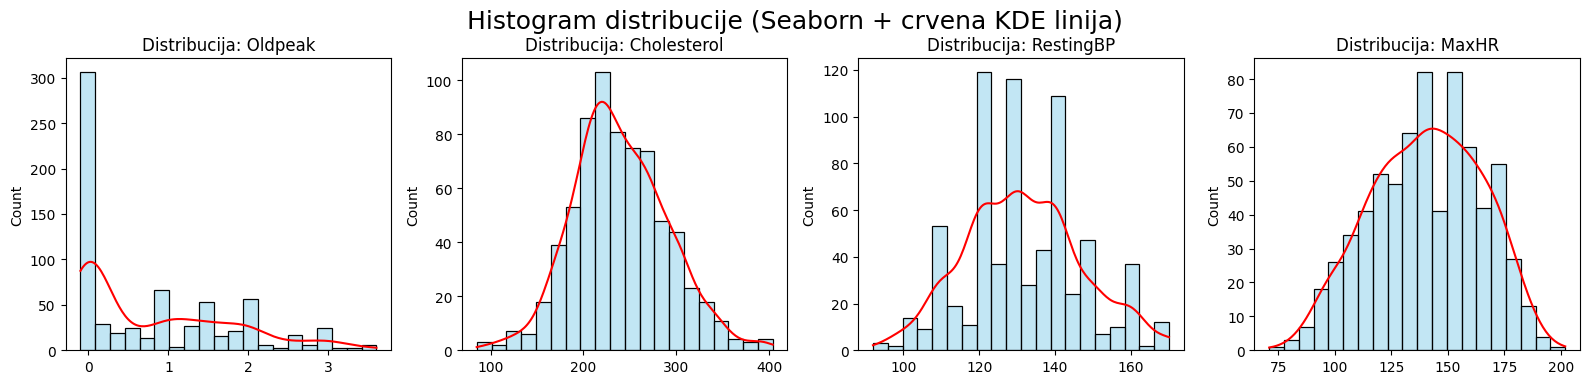

In [543]:
plot_numeric_distributions(df_iqr, noisy_cols)

In [544]:
df_dict['IQR'] = df_iqr

#### LocalOutlierFactor

LOF metoda identifikuje i uklanjanja složene autlajere koji se ne mogu uočiti prostim posmatranjem jedne kolone. Podaci se prvo standardizuju, a zatim algoritam uklanja 5% najsumnjivijih redova (anomalija) na osnovu gustine njihovog okruženja.

In [547]:
df_locoutfac = df_encoded.copy()

X_values = df_locoutfac[noisy_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_scaled)

df_locoutfac = df_locoutfac.iloc[y_pred != -1].copy()

X_scaled_clean = X_scaled[y_pred != -1]
df_locoutfac[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

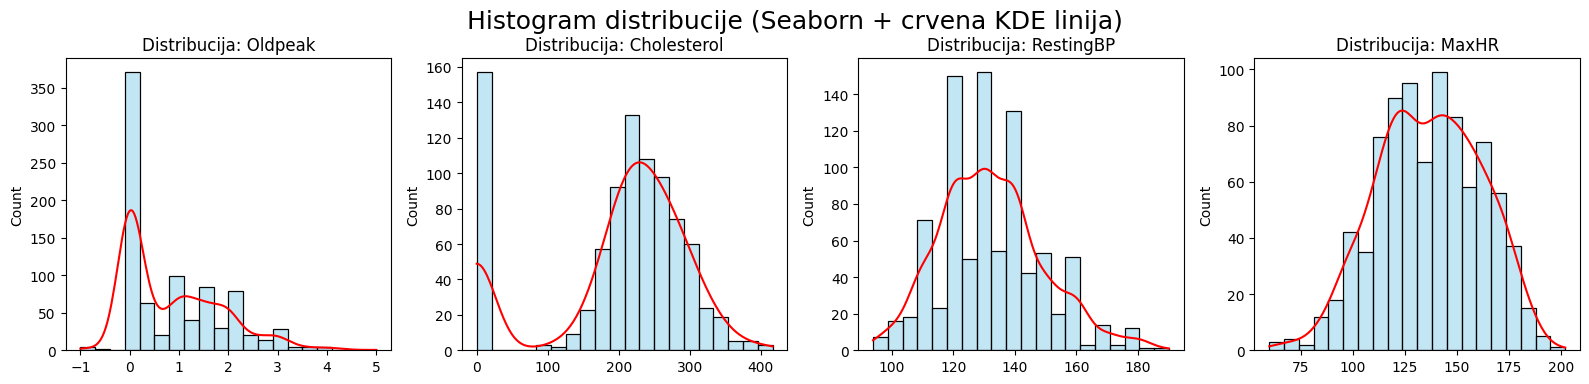

In [550]:
plot_numeric_distributions(df_locoutfac, noisy_cols)

In [552]:
df_dict['LocalOutlierFactor'] = df_locoutfac

#### IsolationForest

Algoritam IsolationForest identifikuje autlajere. Princip rada se zasniva na izolovanju anomalija pomoću nasumičnog deljenja prostora podataka. Pošto su anomalije retke i udaljene, one se lakše (brže) izoluju od ostatka podataka. Uklanjamo 5% najsumnjivijih primera.

In [555]:
df_iforest = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_iforest[noisy_cols])

iso_forest = IsolationForest(contamination=0.05, random_state=42)
y_pred = iso_forest.fit_predict(X_scaled)

mask = y_pred != -1

df_iforest = df_iforest.iloc[mask].copy()

X_scaled_clean = X_scaled[mask]
df_iforest[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

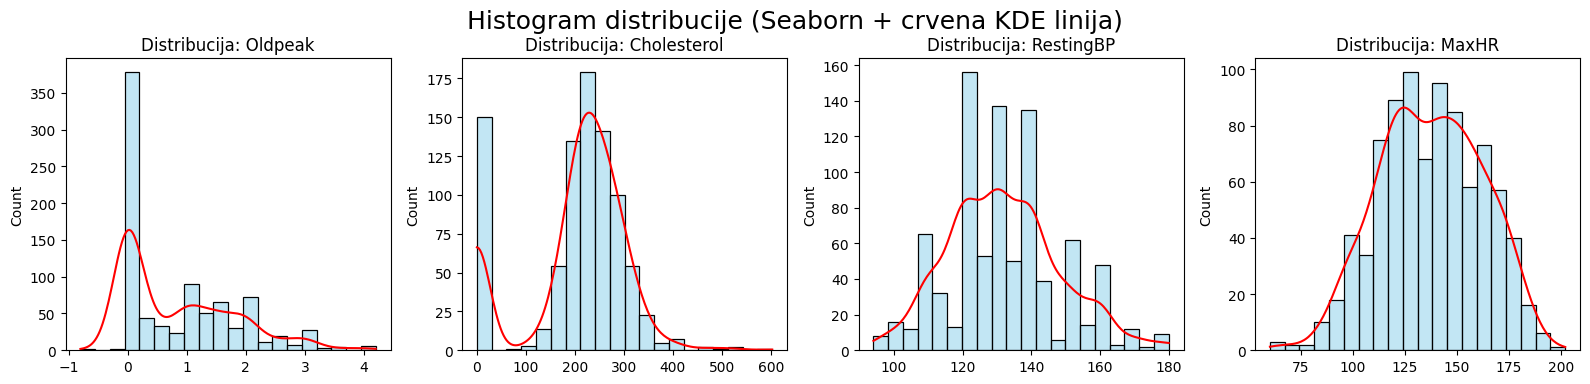

In [557]:
plot_numeric_distributions(df_iforest, noisy_cols)

In [559]:
df_dict['IsolationForest'] = df_iforest

#### KMeans

Anomalije identifikujemo kao tačke koje su najviše udaljene od centra svog dodeljenog klastera. Uklanjamo 5% podataka koji imaju najveće euklidske udaljenosti od svojih centroida (iznad 95. percentila).

In [563]:
df_kmeans = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans[noisy_cols])

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

threshold = np.percentile(distances, 95)

mask = distances <= threshold

df_kmeans = df_kmeans.iloc[mask].copy()

X_scaled_clean = X_scaled[mask]
df_kmeans[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

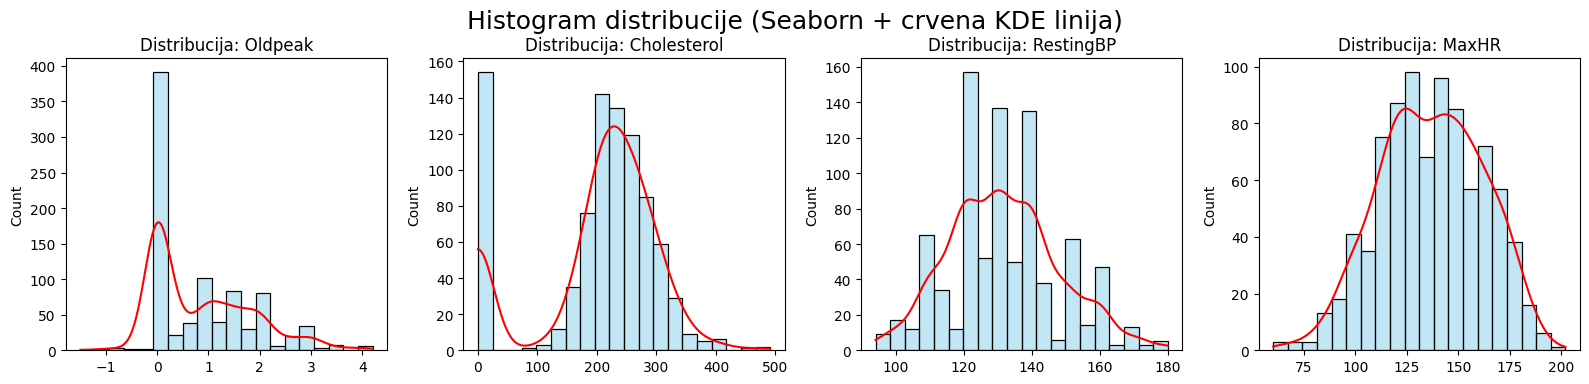

In [564]:
plot_numeric_distributions(df_kmeans, noisy_cols)

In [565]:
df_dict['KMeans'] = df_kmeans

### Filters

#### Ensemble

Ova metoda koristi tri različita algoritma (`Random Forest`, `Gradient Boosting` i `Logistic Regression`) da identifikuje problematične redove. Ako većina modela (više od 50%) pogreši u predviđanju labele za određeni red, taj red se smatra šumom ili anomalijom i uklanja se iz skupa podataka.

In [572]:
filter_algorithms = [
    RandomForestClassifier(n_estimators=50, random_state=42),
    GradientBoostingClassifier(random_state=42),
    make_pipeline(StandardScaler(),
                  LogisticRegression(solver="liblinear", max_iter=5000, random_state=42))
]

X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_filtered = X.copy()
y_filtered = y.copy()

misclassified_counts = np.zeros(len(X_filtered))

for clf in filter_algorithms:
    clf.fit(X_filtered, y_filtered)
    y_pred = clf.predict(X_filtered)
    misclassified_counts += (y_pred != y_filtered)

threshold = len(filter_algorithms) // 2
mask = misclassified_counts <= threshold

X_clean = X_filtered[mask].copy()
y_clean = y_filtered[mask].copy()

X_clean = X_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)
df_ensembl = X_clean.copy()
df_ensembl['HeartDisease'] = y_clean

In [573]:
df_dict['Ensemble'] = df_ensembl

#### CrossValidatedCommittees

Ansambl modela i `cross_val_predict` identifikovaje primere koje je teško klasifikovati. Za razliku od običnog filtra, ovde svaki model predviđa labele za podatke koje nije video tokom treninga. Ako većina modela (glasanjem) pogreši, taj red se uklanja kao potencijalni šum ili nepouzdana informacija.

In [578]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_filtered = X.copy()
y_filtered = y.copy()

misclassified_counts = np.zeros(len(X_filtered))

for clf in filter_algorithms:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X_filtered, y_filtered, cv=skf)
    misclassified_counts += (y_pred != y_filtered)

threshold = len(filter_algorithms) // 2  
mask = misclassified_counts <= threshold

X_clean = X_filtered[mask].copy()
y_clean = y_filtered[mask].copy()

X_clean = X_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)
df_crossval = X_clean.copy()
df_crossval['HeartDisease'] = y_clean

In [579]:
df_dict['CrossValidatedCommittees'] = df_crossval

#### IterativePartitioning

U svakom krugu, podaci se dele na $\gamma$ delova (K-Fold), a `DecisionTreeClassifier` identifikuje primere kod kojih se predviđena labela ne slaže sa stvarnom. Proces se ponavlja sve dok broj detektovanih šumnih podataka ne padne ispod definisanog praga ($p$).

In [584]:
def iterative_partitioning_filter_gentle(X, y, max_iter=3, gamma=5):
    X_arr, y_arr = np.array(X), np.array(y)
    n = len(y_arr)
    DT = np.arange(n)
    
    for iteration in range(max_iter):
        kf = KFold(n_splits=gamma, shuffle=True, random_state=iteration)
        # Matrica u kojoj čuvamo da li je model pogodio (1) ili promašio (0)
        correct_hits = np.zeros((len(DT), gamma))
        
        for i, (train_idx, val_idx) in enumerate(kf.split(DT)):
            train_ids, val_ids = DT[train_idx], DT[val_idx]
            
            clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=iteration)
            clf.fit(X_arr[train_ids], y_arr[train_ids])
            
            preds = clf.predict(X_arr[val_ids])
            # Beležimo gde se predviđanje poklapa sa stvarnom vrednošću
            correct_hits[val_idx, i] = (preds == y_arr[val_ids]).astype(int)

        # Instanca je šum samo ako je SVIH 5 modela (gamma=5) promašilo
        is_noisy = np.sum(correct_hits, axis=1) == 0
        noisy_idx = DT[is_noisy]
        
        print(f"Iteracija {iteration+1}: \nPronađeno ekstremno sumnjivih (konzensus): {len(noisy_idx)}")

        if len(noisy_idx) == 0:
            break
            
        DT = np.setdiff1d(DT, noisy_idx)
        print(f"Preostalo nakon čišćenja: {len(DT)}\n")
    
    return X_arr[DT], y_arr[DT]

In [585]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_clean, y_clean = iterative_partitioning_filter_gentle(X, y)

X_clean = pd.DataFrame(X_clean, columns=X.columns).reset_index(drop=True)
y_clean = pd.Series(y_clean, name='HeartDisease').reset_index(drop=True)
df_ipf = pd.concat([X_clean, y_clean], axis=1)

print(f"\nOriginalni dataset: {len(df_encoded)} instanci")
print(f"Pročišćeni dataset: {len(df_ipf)} instanci")

Iteracija 1: 
Pronađeno ekstremno sumnjivih (konzensus): 116
Preostalo nakon čišćenja: 802

Iteracija 2: 
Pronađeno ekstremno sumnjivih (konzensus): 19
Preostalo nakon čišćenja: 783

Iteracija 3: 
Pronađeno ekstremno sumnjivih (konzensus): 6
Preostalo nakon čišćenja: 777


Originalni dataset: 918 instanci
Pročišćeni dataset: 777 instanci


In [586]:
df_dict['IterativePartitioning'] = df_ipf

### Uklanjanje duplikata

#### Exact Duplicates

In [589]:
df_encoded.duplicated().sum()

0

#### Near Duplicates

Koristimo kombinovanu metriku: Euklidsku udaljenost za numeričke podatke i Hammingovu udaljenost za kategorijske za uklanjanje skoro-duplikata. Ako su dva reda u oba smisla ispod definisanog praga (`threshold`), jedan od njih se uklanja kako bi se smanjila redundantnost i sprečila pristrasnost modela.

25 parova: 


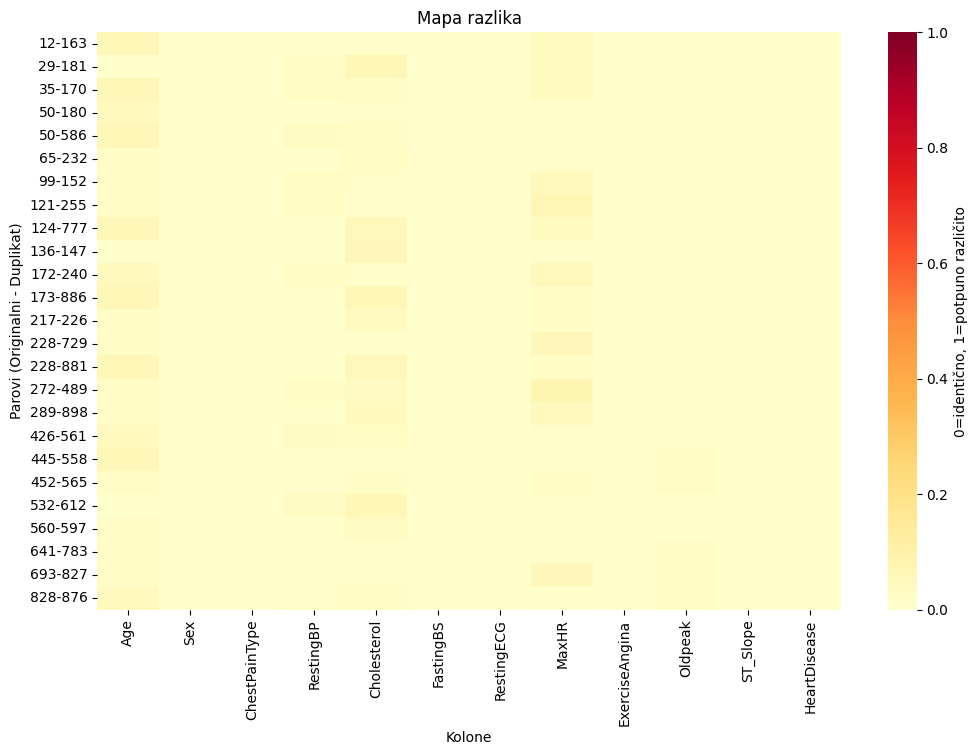


U 100.00% slučajeva, identifikovani duplikati imaju IDENTIČNU dijagnozu (=0).


In [595]:
df_tmp = df.copy()
cat_cols = df_tmp.select_dtypes(include=["object"]).columns.tolist()
num_cols = df_tmp.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
num_data = scaler.fit_transform(df_tmp[num_cols]) if num_cols else np.array([])
cat_data = df_tmp[cat_cols].fillna("").astype(str).values if cat_cols else np.array([])

num_threshold = 0.5  
cat_threshold = 0.1  

to_drop = set()
analysis_data = [] 
n = len(df_tmp)

for i in range(n):
    if i in to_drop: continue
    for j in range(i+1, n):
        if j in to_drop: continue
        
        dist_num = np.linalg.norm(num_data[i] - num_data[j]) if num_cols else 0
        diff_mask = (cat_data[i] != cat_data[j])
        dist_cat = np.mean(diff_mask) if cat_cols else 0
        
        if dist_num < num_threshold and dist_cat <= cat_threshold:
            to_drop.add(j)
            analysis_data.append({'Original_Idx': i, 'Duplicate_Idx': j})

print(f"{len(analysis_data)} parova: ")

if analysis_data:
    diff_matrix = []
    pair_labels = []

    for par in analysis_data:
        idx_orig, idx_dup = par['Original_Idx'], par['Duplicate_Idx']
        row_diffs = {}
        
        for col in df.columns:
            v1, v2 = df.iloc[idx_orig][col], df.iloc[idx_dup][col]
            if pd.api.types.is_numeric_dtype(df[col]):
                r = df[col].max() - df[col].min()
                row_diffs[col] = abs(v1 - v2) / r if r != 0 else 0
            else:
                row_diffs[col] = 1 if str(v1) != str(v2) else 0
        
        diff_matrix.append(row_diffs)
        pair_labels.append(f"{idx_orig}-{idx_dup}")

    df_viz = pd.DataFrame(diff_matrix, index=pair_labels)

    plt.figure(figsize=(12, min(len(df_viz) * 0.3, 15)))
    sns.heatmap(df_viz, 
                cmap="YlOrRd", 
                vmin=0, 
                vmax=1, 
                cbar_kws={'label': '0=identično, 1=potpuno različito'})
    
    plt.title("Mapa razlika")
    plt.xlabel("Kolone")
    plt.ylabel("Parovi (Originalni - Duplikat)")
    plt.show()

    target_col = 'HeartDisease'
    if target_col in df_viz.columns:
        matching_target = (df_viz[target_col] == 0).sum()
        pct = (matching_target / len(df_viz)) * 100
        print(f"\nU {pct:.2f}% slučajeva, identifikovani duplikati imaju IDENTIČNU dijagnozu (=0).")

Visok stepen sličnosti: Dominacija svetle boje na celoj mapi potvrđuje da su analizirani parovi gotovo identični (vrednosti razlika su blizu 0).

Konzistentnost kategoričkih podataka: Kolone poput `Sex`, `ChestPainType` i `HeartDisease` ne pokazuju nikakve razlike, što ukazuje na to da su ključne karakteristike pacijenata u ovim parovima iste.

In [597]:
df_neardup = df_encoded.copy()
df_neardup = df_neardup.drop(index=list(to_drop)).reset_index(drop=True)

print(f"\nOriginalni dataset: {len(df_encoded)} | Nakon čišćenja: {len(df_neardup)}")


Originalni dataset: 918 | Nakon čišćenja: 893


In [598]:
df_dict['NearDuplicates'] = df_neardup

### Dimension reduction

## Feature Selection - embedded

Koristimo logističku regresiju sa $L_1$ penalom kako bismo identifikovali najznačajnije prediktore za srčana oboljenja. $L_1$ regularizacija vrši unutrašnju selekciju tako što kažnjava nebitne atribute i postavlja njihove koeficijente na nulu, ostavljajući nam samo najinformativniji podskup podataka u `df_reduced`.

In [605]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

model = LogisticRegression(penalty='l1', solver='liblinear')  # L1 penal
model.fit(X.values, y)

selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X.values)
selected_features = X.columns[selector.get_support()]

In [606]:
df_reduced = pd.concat([pd.DataFrame(X_selected, columns=selected_features), y.reset_index(drop=True)], axis=1)

In [607]:
df_dict['DimensionReduction']= df_reduced

# Trening

In [609]:
def calculate_metrics(y_test, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    classes = np.unique(y_test)
    if len(classes) == 1:
        roc_auc = 0
    else:
        roc_auc = roc_auc_score(y_test, y_proba)
        
    return {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc
    }

Ova funkcija automatizuje proces podele podataka, skaliranja i treniranja tri različita klasifikatora.

Klasifikatori koji su korišćeni:
* `Random Forest`,
* `SVM` i
* `Logistička regresija`.

Na osnovu predviđanja modela, funkcija izračunava i vraća uporedne metrike performansi kako bi se olakšala evaluacija rezultata na zadatom skupu podataka.

In [611]:
def TrainAndReturnSpecs(df, df_name="Dataset"):
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
        'SVM': SVC(probability=True, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42)
    }
    
    all_results = []

    for name, model in models.items():
        print(f"Trening: {name} - {df_name}...")
        
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        metrics = calculate_metrics(y_test, y_pred, y_proba)
        
        res = {
            'Model': name,
            **metrics
        }
        all_results.append(res)
        
    return all_results

In [612]:
result_dict = dict()

In [613]:
for key, value in df_dict.items():
    result_dict[key] = TrainAndReturnSpecs(value, key)
    print('\n')

Trening: RandomForest - Original...
Trening: SVM - Original...
Trening: LogisticRegression - Original...


Trening: RandomForest - Binning...
Trening: SVM - Binning...
Trening: LogisticRegression - Binning...


Trening: RandomForest - Regression...
Trening: SVM - Regression...
Trening: LogisticRegression - Regression...


Trening: RandomForest - IQR...
Trening: SVM - IQR...
Trening: LogisticRegression - IQR...


Trening: RandomForest - LocalOutlierFactor...
Trening: SVM - LocalOutlierFactor...
Trening: LogisticRegression - LocalOutlierFactor...


Trening: RandomForest - IsolationForest...
Trening: SVM - IsolationForest...
Trening: LogisticRegression - IsolationForest...


Trening: RandomForest - KMeans...
Trening: SVM - KMeans...
Trening: LogisticRegression - KMeans...


Trening: RandomForest - Ensemble...
Trening: SVM - Ensemble...
Trening: LogisticRegression - Ensemble...


Trening: RandomForest - CrossValidatedCommittees...
Trening: SVM - CrossValidatedCommittees...
Trening: Logisti

# Poređenje rezultata

In [615]:
flat_data = []
for dataset_name, models in result_dict.items():
    for m in models:
        row = {'Dataset': dataset_name}
        row.update(m)
        flat_data.append(row)

df_results = pd.DataFrame(flat_data)

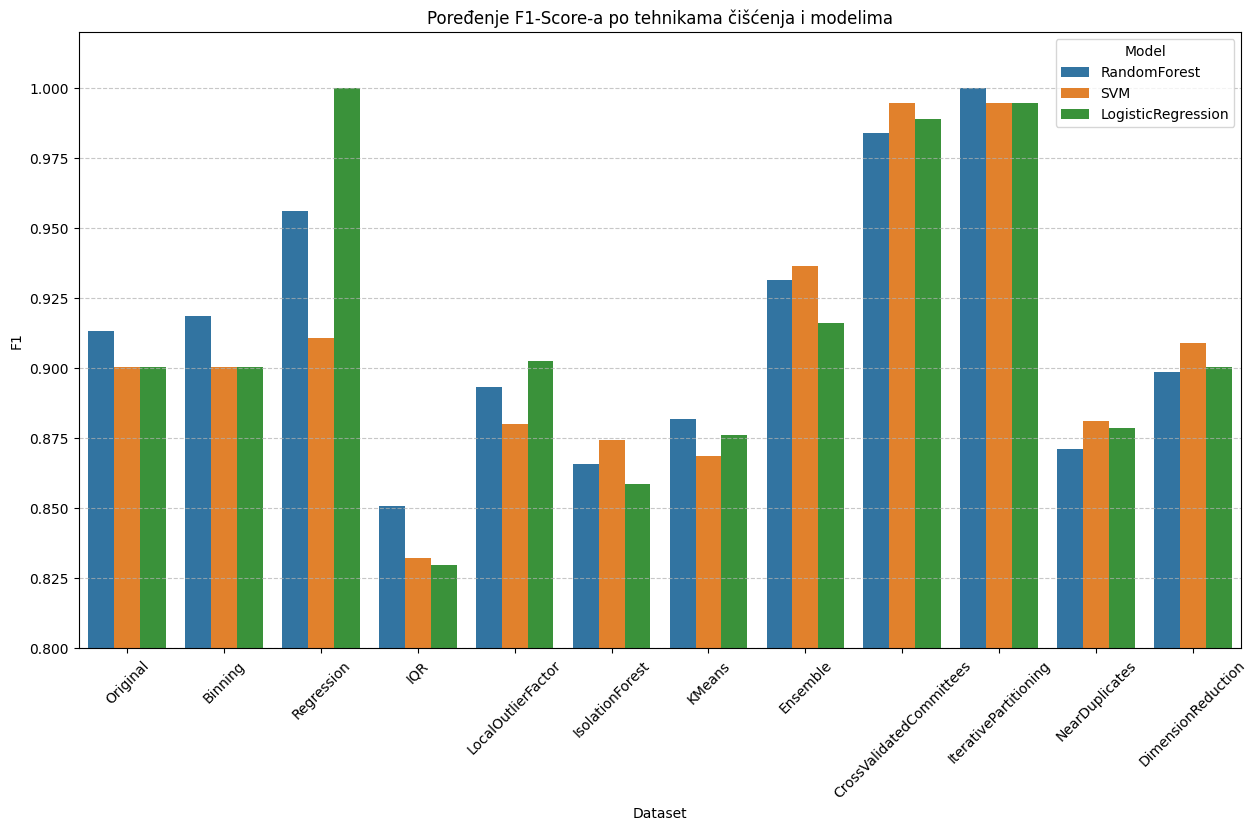

In [616]:
plt.figure(figsize=(15, 8))
sns.barplot(data=df_results, x='Dataset', y='F1', hue='Model')
plt.xticks(rotation=45)
plt.title('Poređenje F1-Score-a po tehnikama čišćenja i modelima')
plt.ylim(0.8, 1.02)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Top Performers**

* `IterativePartitioning` i `CrossValidatedCommittees`: Ove tehnike su se pokazale kao univerzalno najbolje za sve modele.
    * **Random Forest** dostiže svoj maksimum (F1=1.0) na `IterativePartitioning`, dok su **SVM** i **Logistic Regression** na istom nivou stabilnosti.
    * **Regression**: Ova tehnika čišćenja je najviše pogodovala `Logističkoj regresiji`, gde ona ostvaruje savršen rezultat (F1=1.0), nadmašujući čak i kompleksniji Random Forest na istom skupu.

**Worst Performers** - vrednosti za F1 i dalje nisu niske

* `IQR`: Svi modeli pokazuju drastičan pad performansi.
* `KMeans`, `IsolationForest` i `NearDuplicates`.

In [618]:
rf_results = {}
svm_results = {}
lr_results = {}

for dataset_name, models_list in result_dict.items():
    for entry in models_list:
        model_name = entry['Model']
        
        metrics_only = {k: v for k, v in entry.items() if k != 'Model'}
        
        if model_name == 'RandomForest':
            rf_results[dataset_name] = metrics_only
        elif model_name == 'SVM':
            svm_results[dataset_name] = metrics_only
        elif model_name == 'LogisticRegression':
            lr_results[dataset_name] = metrics_only

Ova funkcija dodeljuje rangove svakom modelu na osnovu svih metrika u tabeli, a zatim identifikuje najbolju tehniku kao onu sa najmanjim zbirom rangova.

## Analiza svih metrika po modelu

In [621]:
def ranking(df):
    df_ranks = df.rank(ascending=False, method='min')
    df_ranks['sum_rank'] = df_ranks.sum(axis=1)
    df_sorted = df_ranks.sort_values('sum_rank')
    display(df_sorted)

    print(f"Najbolja tehnika za model: {df_sorted.index[0]}")

In [622]:
def model_analysis(results, name):
    df_results = pd.DataFrame(results).T
    df_results = df_results.apply(pd.to_numeric)
    
    plt.figure(figsize=(10,6))
    sns.heatmap(df_results, annot=True, cmap="YlGnBu", fmt=".3f")
    plt.title(f"{name}")
    plt.show()

    ranking(df_results)

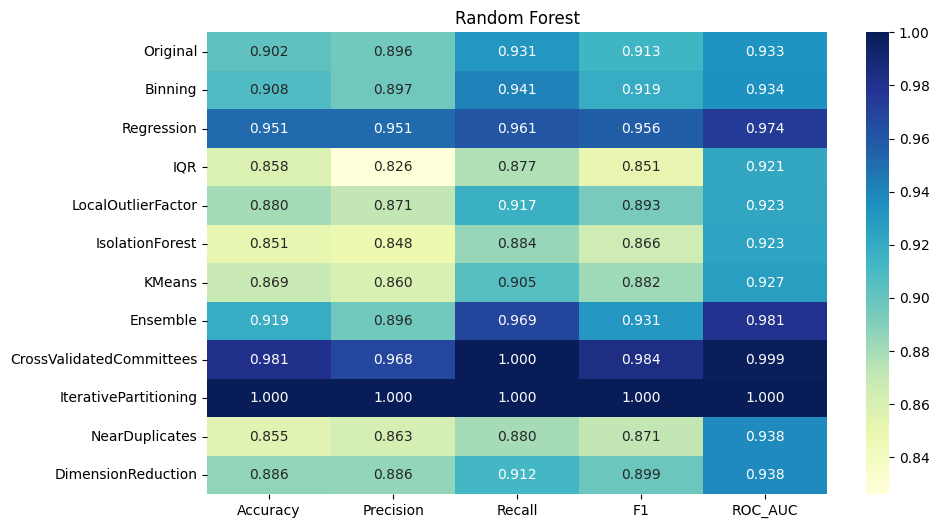

,Accuracy,Precision,Recall,F1,ROC_AUC,sum_rank
IterativePartitioning,1.0,1.0,1.0,1.0,1.0,5.0
CrossValidatedCommittees,2.0,2.0,1.0,2.0,2.0,9.0
Regression,3.0,3.0,4.0,3.0,4.0,17.0
Ensemble,4.0,5.0,3.0,4.0,3.0,19.0
Binning,5.0,4.0,5.0,5.0,7.0,26.0
Original,6.0,5.0,6.0,6.0,8.0,31.0
DimensionReduction,7.0,7.0,8.0,7.0,5.0,34.0
LocalOutlierFactor,8.0,8.0,7.0,8.0,11.0,42.0
KMeans,9.0,10.0,9.0,9.0,9.0,46.0
NearDuplicates,11.0,9.0,11.0,10.0,6.0,47.0


Najbolja tehnika za model: IterativePartitioning


In [623]:
model_analysis(rf_results, "Random Forest")

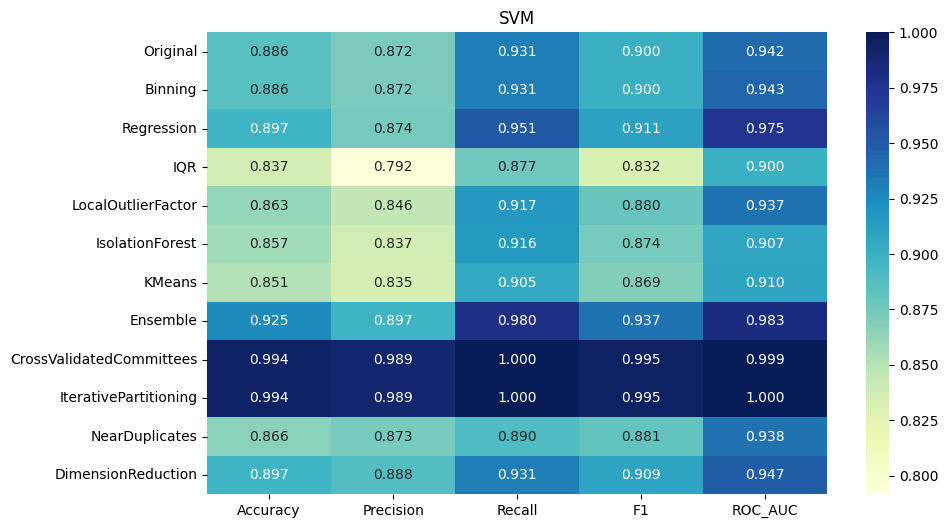

,Accuracy,Precision,Recall,F1,ROC_AUC,sum_rank
CrossValidatedCommittees,1.0,1.0,1.0,1.0,2.0,6.0
IterativePartitioning,2.0,1.0,1.0,1.0,1.0,6.0
Ensemble,3.0,3.0,3.0,3.0,3.0,15.0
Regression,4.0,5.0,4.0,4.0,4.0,21.0
DimensionReduction,4.0,4.0,5.0,5.0,5.0,23.0
Binning,6.0,7.0,5.0,6.0,6.0,30.0
Original,6.0,7.0,5.0,6.0,7.0,31.0
NearDuplicates,8.0,6.0,11.0,8.0,8.0,41.0
LocalOutlierFactor,9.0,9.0,8.0,9.0,9.0,44.0
IsolationForest,10.0,10.0,9.0,10.0,11.0,50.0


Najbolja tehnika za model: CrossValidatedCommittees


In [624]:
model_analysis(svm_results, "SVM")

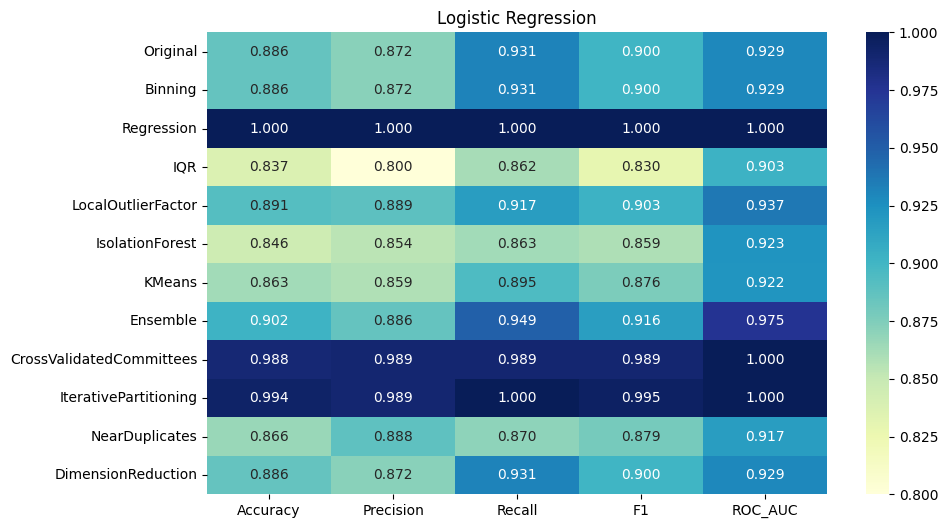

,Accuracy,Precision,Recall,F1,ROC_AUC,sum_rank
Regression,1.0,1.0,1.0,1.0,1.0,5.0
IterativePartitioning,2.0,2.0,1.0,2.0,1.0,8.0
CrossValidatedCommittees,3.0,3.0,3.0,3.0,3.0,15.0
Ensemble,4.0,6.0,4.0,4.0,4.0,22.0
LocalOutlierFactor,5.0,4.0,8.0,5.0,5.0,27.0
Binning,6.0,7.0,5.0,6.0,6.0,30.0
Original,6.0,7.0,5.0,6.0,7.0,31.0
DimensionReduction,6.0,7.0,5.0,6.0,8.0,32.0
NearDuplicates,9.0,5.0,10.0,9.0,11.0,44.0
KMeans,10.0,10.0,9.0,10.0,10.0,49.0


Najbolja tehnika za model: Regression


In [625]:
model_analysis(lr_results, "Logistic Regression")